In [83]:
import xarray as xr
import rioxarray as rix
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

### 1. Prepare DEM data

In [84]:
elevation_raster = rix.open_rasterio("../data/east_river_elevation.tif")

elevation_raster.rio.to_raster(
    "../data/openamundsen/dem_uppereastriver_50.asc", driver='AAIGrid'
)

In [85]:
print(elevation_raster.rio.crs)

EPSG:32613


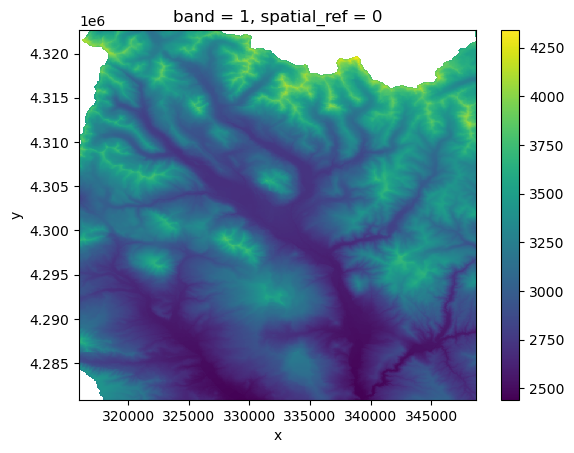

In [86]:
elevation_raster = rix.open_rasterio("../data/openamundsen/dem_uppereastriver_50.asc")
elevation_raster.plot()

The file `dem_uppereastriver_50.asc` can be used by openamundsen.

### 2. Prepare ROI data

Create a raster mask using the ASC DEM and the Upper East River polygon

In [87]:
upper_east_river_polygon = gpd.read_file("../data/east_polygon.json").to_crs(
    elevation_raster.rio.crs
)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

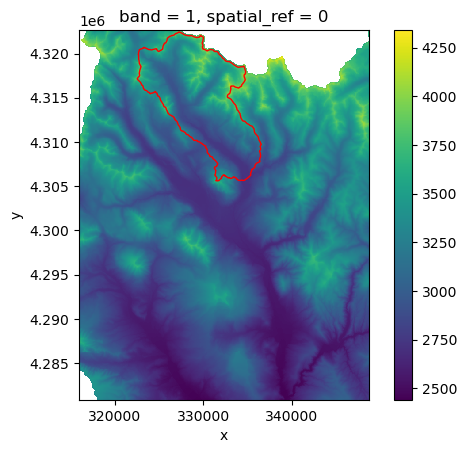

In [88]:
fig, ax = plt.subplots()
elevation_raster.plot(ax=ax)
upper_east_river_polygon.plot(edgecolor='red', facecolor='None', ax=ax)

Create the mask by doing some clipping with the geometry

In [89]:
not_in_bounds = elevation_raster.rio.clip(upper_east_river_polygon.geometry, drop=False,)
in_bounds = elevation_raster.rio.clip(upper_east_river_polygon.geometry, drop=False, invert=True)

In [90]:
# identify in bounds areas as 0
in_bounds = in_bounds.where(np.isnan(in_bounds), 1, 0)
# identify out of bounds areas as 1
not_in_bounds = not_in_bounds.where(np.isnan(not_in_bounds), 0, 1)
# combine the two datasets
mask_raster = in_bounds.fillna(not_in_bounds)
# swap the 0 and 1 values
mask_raster = mask_raster.where(mask_raster != 1, -1)  # Temporarily set 1s to -1
mask_raster = mask_raster.where(mask_raster != 0, 1)   # Set 0s to 1
mask_raster = mask_raster.where(mask_raster != -1, 0)  # Set -1s (originally 1s) to 0

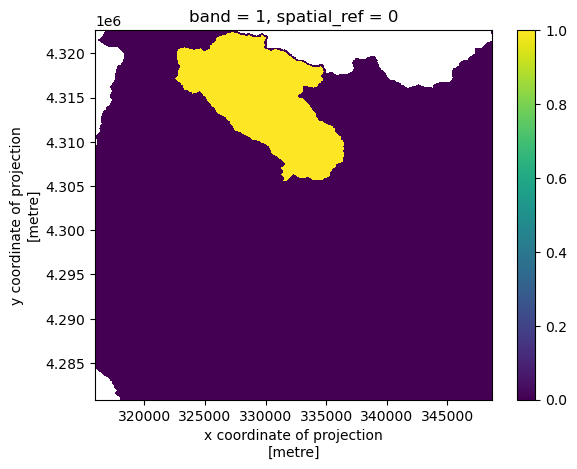

In [91]:
mask_raster.plot()

In [92]:
mask_raster.rio.to_raster(
    "../data/openamundsen/roi_uppereastriver_50.asc", driver='AAIGrid'
)

The file `roi_uppereastriver_50.asc` can be used by openamundsen.

# Prepare met inputs

Open the two datasets

In [93]:
inputs_ds = xr.open_dataset('../data/sos_full_dataset_30min.nc')

inputs_precip_df = pd.read_csv('../data/kettle_ponds_precip_30min.csv')
inputs_precip_df = inputs_precip_df.set_index('time')
inputs_precip_df.index = pd.to_datetime(inputs_precip_df.index)
inputs_precip_df['isnan'] = np.isnan(inputs_precip_df['precip_rate']).astype('int')

(np.float64(19426.0), np.float64(19428.0))

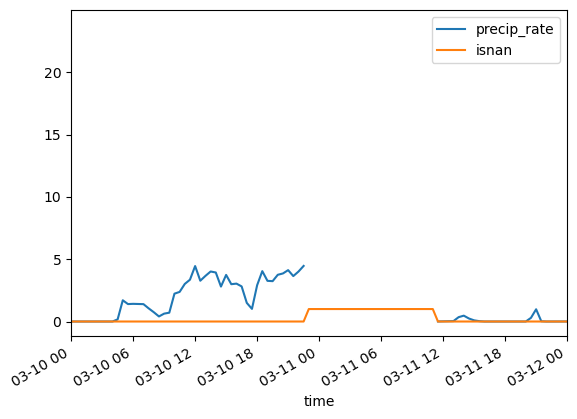

In [94]:
inputs_precip_df.plot()
plt.xlim('20230310', '20230312')

(np.float64(19468.0), np.float64(19471.0))

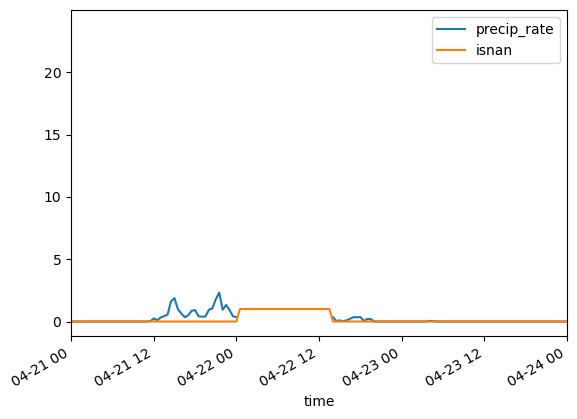

In [95]:
inputs_precip_df.plot()
plt.xlim('20230421', '20230424')

Get the met inputs we need from SOS measurements

In [96]:
inputs_df = inputs_ds[[
    'T_3m_c',
    'RH_3m_c',
    'Rsw_in_9m_d',
    'spd_3m_c'
]].to_dataframe()

Merge the SOS measurements with the SAIL laser disdrometer precipitation

In [97]:
inputs_df = inputs_df.join(inputs_precip_df, how='inner')

Rename the input variables to match the requirements

In [98]:
inputs_df = inputs_df.rename(columns={
    'T_3m_c':       'temp',
    'RH_3m_c':      'rel_hum',
    'Rsw_in_9m_d':  'sw_in',
    'spd_3m_c':     'wind_speed',
    'precip_rate':  'precip',
})

Fill nans with forward filling

In [99]:
inputs_df = inputs_df.fillna(0)

Convert temp from ˚C to K

In [100]:
inputs_df['temp'] = inputs_df['temp'] + 273.15

Convert precip in rate of mm/hr to precipitation sum per interval in units kg/m^2 (same as mm)

In [101]:
from metpy.units import units
from metpy.constants import density_ice, density_water

In [102]:
inputs_df['precip'].max()

np.float64(23.807367)

In [103]:
new_precip_values = (
    (    
        (
            inputs_df['precip'].values * units ("mm/hr")
        ).to(units("mm / (30 minutes)")) * 30*units("minutes")
    ) * density_ice
).to(units("kg/m^2")).magnitude
inputs_df['precip'] = new_precip_values

In [104]:
inputs_df['precip'].max()

np.float64(10.9156777695)

# APPLY ADJUSTMENT FACTOR TO PRECIP SO THE VALUES AREN'T WILD OUT HERE!

The disdrometer data is way off

<Axes: xlabel='time'>

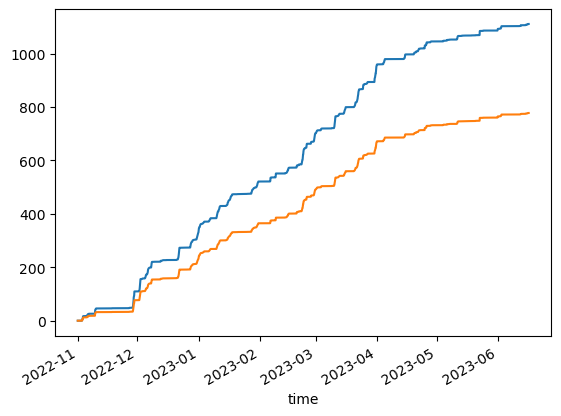

In [105]:
(inputs_df['precip']).cumsum().plot()
(inputs_df['precip']*0.7).cumsum().plot()

In [106]:
inputs_df['precip'] = inputs_df['precip']*0.7*0.5

<Axes: xlabel='time'>

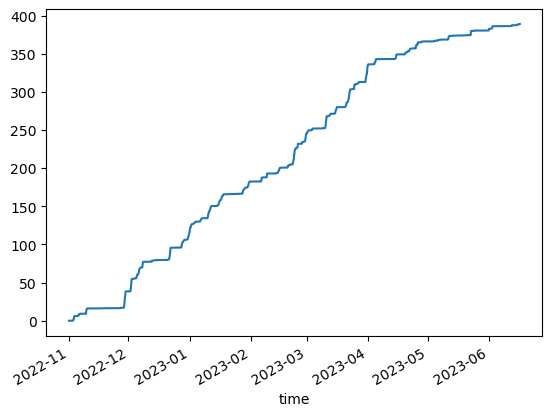

In [107]:
(inputs_df['precip']).cumsum().plot()

name the index `date`

In [108]:
inputs_df.index.name = 'date'

Convert to UTC, remove dates from around daylight savings time in november b/c it messes things up

In [109]:
inputs_df = inputs_df.loc["2022-11-10": "2023-06-15"]
inputs_df.index = inputs_df.index.tz_localize('US/Mountain').tz_convert('UTC').tz_localize(None)

Check that all timestamps are evenly spaced

In [110]:
index_diff = inputs_df.loc["2022-11-16": "2023-06-15"].index.diff()
index_diff.value_counts()

date
0 days 00:30:00    10175
Name: count, dtype: int64

Save inputs to a file

In [111]:
inputs_df = inputs_df.reset_index()

In [112]:
inputs_df.to_csv("../data/openamundsen/1.csv", index=False)

The file `kps_model_met.csv` can be used by openamundsen.

# Prepare stations.csv file

In [113]:
elevation_raster.sel(
        x=329008.940,
        y=4312170.815,
        method='nearest'
    ).values.item()

2858.254638671875

In [114]:
stations_df = pd.DataFrame({
    'id':      ["1"], # needs to match filename containing met data
    'name':    ["kps"],
    'x':       [329009],      # x coord for KPS in proper CRS
    'y':       [4312171],     # y coord for KPS in proper CRS
    'alt':     ["2858"],
})

stations_df

,id,name,x,y,alt
0,1,kps,329009,4312171,2858


In [115]:
stations_df.to_csv("../data/openamundsen/stations.csv", index=False)

# Summary

We created the files:

In [116]:
ls ../data/openamundsen/

1.csv                              roi_uppereastriver_50.asc.aux.xml
dem_uppereastriver_50.asc          roi_uppereastriver_50.prj
dem_uppereastriver_50.asc.aux.xml  stations.csv
dem_uppereastriver_50.prj          svf_uppereastriver_50.asc
roi_uppereastriver_50.asc


# Check out some sample files

In [117]:
src = pd.read_csv("/Users/elischwat/Downloads/2023-037_Data_Rofental_UIBK/1_BellaVista_10min_2015-2023.csv", skiprows=2)

In [118]:
src

,Date and time,Vaisala air temperature (deg C),Vaisala air humidity (per cent),Vaisala precipitation (mm/interval),Vaisala mean wind speed (m/s),Vaisala mean wind direction (deg),Vaisala maximum wind speed (m/s),Vaisala air pressure (hPa),EE08 air temperature (deg C),EE08 air humidity (per cent),...,SCA snow temperature 20 cm II (deg C),SCA snow temperature 40 cm II (deg C),SCA snow temperature 60 cm II (deg C),SCA snow temperature 80 cm II (deg C),SCA snow temperature 100 cm II (deg C),SND min. snow drift (g/m2),SND avg. snow drift (g/m2),SND max. snow drift (g/m2),SND std. snow drift (g/m2),SND cum. snow drift (g/m2)
0,2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-01 00:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473323,2023-12-31 23:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473324,2023-12-31 23:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473325,2023-12-31 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473326,2023-12-31 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
